In [1]:
from IPython import display

import msprime
import numpy as np
import tskit

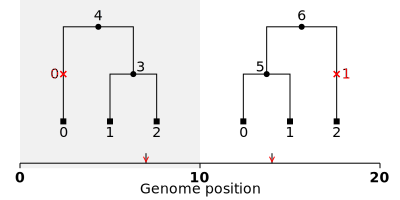

In [130]:
ts = tskit.load("../tree-simple-1.tree")
# ts = tskit.load("../test.tree")
ts.draw_svg()

In [353]:
list(ts.sites())

[Site(id=0, position=7.0, ancestral_state='A', mutations=[Mutation(id=0, site=0, node=0, derived_state='T', parent=-1, metadata=b'', time=nan, edge=4)], metadata=b''),
 Site(id=1, position=14.0, ancestral_state='G', mutations=[Mutation(id=1, site=1, node=2, derived_state='A', parent=-1, metadata=b'', time=nan, edge=6)], metadata=b'')]

In [131]:
def pairs_with_replacement(n):
    subloop_start = 0
    for i in range(n):
        for j in range(subloop_start, n):
            yield i, j
        subloop_start += 1

In [132]:
def next_state_at(ts, tj, tk, t_left, sample_sets, parent=None, state=None, left_child=None, right_child=None, left_sib=None, right_sib=None):
    I = ts.indexes_edge_insertion_order
    O = ts.indexes_edge_removal_order
    parent = -np.ones(ts.num_nodes, dtype=np.int32) if parent is None else parent

    state = np.zeros((ts.num_nodes, len(sample_sets)), dtype=np.int32) if state is None else state

    left_child = -np.ones(ts.num_nodes, dtype=np.int32) if left_child is None else left_child 
    right_child = -np.ones(ts.num_nodes, dtype=np.int32) if right_child is None else right_child
    left_sib = -np.ones(ts.num_nodes, dtype=np.int32) if left_sib is None else left_sib
    right_sib = -np.ones(ts.num_nodes, dtype=np.int32) if right_sib is None else right_sib

    for i, sample_set in enumerate(sample_sets):
        state[sample_set, i] = 1
    
    while (tk < ts.num_edges) and (ts.edges_right[O[tk]] == t_left):
        h = O[tk]
        tk += 1
        u = ts.edges_child[h]
        v = ts.edges_parent[h]
    
        while (v != -1):
            # print(state[u])
            # display.display(ts.draw_svg(size=(1000, 300), style=f'.a{v}.n{u} > .edge {{stroke: red; stroke-width: 2px}}'))
            state[v] += -state[u]

            if left_sib[u] == -1:
                left_child[v] = right_sib[u]
            else:
                right_sib[left_sib[u]] = right_sib[u]
            if right_sib[u] == -1:
                right_child[v] = left_sib[u]
            else:
                left_sib[right_sib[u]] = left_sib[u]
            left_sib[u] = -1
            right_sib[u] = -1

            v = parent[v]
        parent[u] = -1
    while (tj < ts.num_edges) and (ts.edges_left[I[tj]] == t_left):
        h = I[tj]
        tj += 1
        u = ts.edges_child[h]
        v = ts.edges_parent[h]
        parent[u] = v
        while (v != -1):
            # print(state[u])
            # display.display(ts.draw_svg(size=(1000, 300), style=f'.a{v}.n{u} > .edge {{stroke: cyan; stroke-width: 2px}}'))
            state[v] += state[u]

            c = right_child[v]
            if c == -1:
                left_child[v] = u
                left_sib[u] = -1
                right_sib[u] = -1
            else:
                right_sib[c] = u
                left_sib[u] = c
                right_sib[u] = -1

            right_child[v] = u

            v = parent[v]
    t_right = ts.sequence_length
    if (tj < ts.num_edges):
        t_right = min(t_right, ts.edges_left[I[tj]])
    if (tk < ts.num_edges):
        t_right = min(t_right, ts.edges_right[O[tk]])

    t_left = t_right
    return tj, tk, t_left, parent, left_child, right_child, left_sib, right_sib, state

In [361]:
def track_ab_haplotypes(ts, tk_left, tj_left, tk_right, tj_right, t_left_right, left_child, right_child, mutation_id, state, parent):
    I = ts.indexes_edge_insertion_order
    O = ts.indexes_edge_removal_order

    mut_parent = ts.edge(ts.mutation(mutation_id).edge).parent
    if ts.edges_parent[mut_parent - 1] == mut_parent:
        prune_edge = mut_parent - 1
    elif ts.edges_parent[mut_parent + 1] == mut_parent:
        prune_edge = mut_parent + 1
    else:
        raise Exception('Unexpected condition')

    state = state.copy()
    state[ts.edge(prune_edge).parent] -= state[ts.edge(prune_edge).child]

    # print(state)
    # prune the state so that we can get the starting state
    stack = []
    stack.append(ts.edge(prune_edge).child)
    while len(stack) > 0:
        node = stack.pop()
        state[node] -= state[node]
        if right_child[node] != -1:
            stack.append(right_child[node])
        if left_child[node] != -1:
            stack.append(left_child[node])

    # print(state)
    # play diffs between both trees
    for tk in range(tk_left, tk_right):
        k = O[tk]
        u = ts.edges_parent[k]
        c = ts.edges_child[k]
        state[u] -= state[c]
        # print(f'removing {u} {c}')
        # while u != -1:
        #     state[u] -= state[c]
        #     u = parent[u]
            
    for tj in range(tj_left, tj_right):
        k = I[tj]
        u = ts.edges_parent[k]
        c = ts.edges_child[k]
        state[u] += state[c]
        # print(f'adding {u} {c}')
        # while u != -1:
        #     state[u] += state[c]
        #     u = parent[u]

    # apply the edge diffs for the next tree
    return state

In [363]:
track_ab_haplotypes(ts, tk_left, tj_left, tk_right, tj_right, t_left_right, left_child_left, right_child_left, 0, state_left, parent_right)

array([[1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1]], dtype=int32)

In [340]:
def get_allele_weights(site, state):
    allele_mat = np.zeros((len(site.mutations) + 1, len(sample_sets)))
    allele_states = [site.ancestral_state]
    num_alleles = 1
    allele = 0
    allele_mat[allele] = np.array(list(map(len, sample_sets)))  # This is not really total weight... I'm just assuming that all samples are either 1 or 0
    for mutation in site.mutations:

        if mutation.derived_state in allele_states:
            allele = allele_states.index(mutation.derived_state)
        else:
            allele_states.append(mutation.derived_state)
            allele = len(allele_states) - 1
            num_alleles += 1
        allele_mat[allele] += state[mutation.node]

        alt_allele = allele_states.index(site.ancestral_state)
        if mutation.parent != -1:
            # TODO haven't exercised this code path yet
            alt_allele = allele_states.index(site.mutations[mutation.parent - site.mutations[0].id].derived_state)
        allele_mat[alt_allele] -= state[mutation.node]

    return num_alleles, allele_mat

In [305]:
# def n_combos_w_replacement(n, k):
#     return int(np.math.factorial(n + k - 1) / (np.math.factorial(k) * np.math.factorial(n - 1)))

In [349]:
def get_linked_allele_weights(site_left, site_right, ts, tk_left, tj_left, tk_right, tj_right, t_left_right, left_child_left, right_child_left, state_left, parent_right):
    allele_mat = np.zeros(((len(site_left.mutations) + 1) * (len(site_right.mutations) + 1), len(sample_sets)))
    allele_states = [site_left.ancestral_state + site_right.ancestral_state]
    allele = 0
    allele_mat[allele] = np.array(list(map(len, sample_sets)))
    # allele_mat[allele] *= 2

    print(allele_states)
    for mutation_left in site_left.mutations:
        state = track_ab_haplotypes(ts, tk_left, tj_left, tk_right, tj_right, t_left_right, left_child_left, right_child_left, mutation_left.id, state_left, parent_right)
        print(state)
        num_alleles = 1
        allele = 0
        for mutation_right in site_right.mutations:
            key = mutation_left.derived_state + mutation_right.derived_state
            if key in allele_states:
                allele = allele_states.index(key)
            else:
                allele_states.append(key)
                allele = len(allele_states) - 1
                num_alleles += 1
            allele_mat[allele] += state[mutation_right.node]

            # alt_allele = allele_states.index(
            #     (site_left.ancestral_state if site_left.ancestral_state != -1 else "") + (site_right.ancestral_state if site_right.ancestral_state != -1 else "")
            # )
            alt_allele_str = ""
            for mutation in [mutation_left, mutation_right]:
                if mutation.parent != -1:
                    # TODO haven't exercised this code path yet
                    alt_allele_str += site.mutations[mutation.parent - site.mutations[0].id].derived_state
                else:
                    alt_allele_str += ts.site(mutation.site).ancestral_state
            alt_allele = allele_states.index(alt_allele_str)
            # for mutation in [mutation_left, mutation_right]:
            allele_mat[alt_allele] -= state[mutation.node]

    # return num_alleles, allele_mat
    return allele_mat, allele_states

In [342]:
left_site

Site(id=1, position=14.0, ancestral_state='G', mutations=[Mutation(id=1, site=1, node=2, derived_state='A', parent=-1, metadata=b'', time=nan, edge=6)], metadata=b'')

In [343]:
right_site

Site(id=1, position=14.0, ancestral_state='G', mutations=[Mutation(id=1, site=1, node=2, derived_state='A', parent=-1, metadata=b'', time=nan, edge=6)], metadata=b'')

In [350]:
get_linked_allele_weights(left_site, right_site, ts, tk_left, tj_left, tk_right, tj_right, t_left_right, left_child_left, right_child_left, state_left, parent_right)

['AG']
[[1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]]


(array([[3.],
        [0.],
        [0.],
        [0.]]),
 ['AG', 'TA'])

In [345]:
# sample_sets = [[0, 1, 2], [3, 4, 5], [4, 5, 6], [1, 2]]
# sample_sets = [[0, 1, 2]]
sample_sets = [list(ts.samples())]

tj_left = 0
tk_left = 0
t_left_left = 0
tree_index_left = 0
parent_left = None
state_left = None

left_child_left = None
right_child_left = None
left_sib_left = None
right_sib_left = None

tj_right = 0
tk_right = 0
t_left_right = 0
tree_index_right = 0
parent_right = None
state_right = None

left_child_right = None
right_child_right = None
left_sib_right = None
right_sib_right = None


last = False

while (tj_left < ts.num_edges) or (t_left_left < ts.sequence_length):
    treeseq_state_left = next_state_at(
        ts=ts, tj=tj_left, tk=tk_left, t_left=t_left_left,
        sample_sets=sample_sets, parent=parent_left, state=state_left,
        left_child=left_child_left, right_child=right_child_left,
        left_sib=left_sib_left, right_sib=right_sib_left
    )
    tj_left, tk_left, t_left_left, parent_left, left_child_left, right_child_left, left_sib_left, right_sib_left, state_left = treeseq_state_left
    tj_right, tk_right, t_left_right, parent_right, left_child_right, right_child_right, left_sib_right, right_sib_right, state_right = treeseq_state_left
    parent_right = parent_right.copy()
    state_right = state_right.copy()
    left_child_right = left_child_right.copy()
    right_child_right = right_child_right.copy()
    left_sib_right = left_sib_right.copy()
    right_sib_right = right_sib_right.copy()

    tree_index_right = tree_index_left

    if (tj_right >= ts.num_edges) or (t_left_right >= ts.sequence_length):  # TODO: there must be a better way to do this.
        last = True

    while (tj_right < ts.num_edges) or (t_left_right < ts.sequence_length) or last:
        if tree_index_left != tree_index_right:  # TODO: there must be a better way to do this.
            treeseq_state_right = next_state_at(
                ts=ts, tj=tj_right, tk=tk_right, t_left=t_left_right,
                sample_sets=sample_sets, parent=parent_right, state=state_right,
                left_child=left_child_right, right_child=right_child_right,
                left_sib=left_sib_right, right_sib=right_sib_right
            )
            tj_right, tk_right, t_left_right, parent_right, left_child_right, right_child_right, left_sib_right, right_sib_right, state_right = treeseq_state_right

        num_sites_left = ts.at_index(tree_index_left).num_sites
        num_sites_right = ts.at_index(tree_index_right).num_sites
        left_sites = list(ts.at_index(tree_index_left).sites())  # ts->tree_sites[tree_index_left]
        right_sites = list(ts.at_index(tree_index_right).sites())

        # print('left tk ', tk_left, 'tj', tj_left, 't_left', t_left_left)
        # print('right tk ', tk_right, 'tj', tj_right, 't_right', t_left_right)
        # print('-----')
        # if t_left_left == 10.0 and t_left_right == 20.0:
        #     raise Exception

        if tree_index_left != tree_index_right:
            for i in range(num_sites_left):
                for j in range(num_sites_right):
                    left_site = left_sites[i]
                    right_site = right_sites[j]
                    num_alleles_left, allele_mat_left = get_allele_weights(left_site, state_left)
                    num_alleles_right, allele_mat_right = get_allele_weights(right_site, state_right)
                    # get_linked_allele_weights(
                    # print(track_ab_haplotypes(ts, tk_left, tj_left, tk_right, tj_right, t_left_right, left_child_left, right_child_left, 0, state_left, parent_right))
                    raise Exception
        else:
            assert num_sites_left == num_sites_right
            for i, j in pairs_with_replacement(num_sites_left):
                left_site = left_sites[i]
                right_site = right_sites[j]
                num_alleles_left, allele_mat_left = get_allele_weights(left_site, state_left)
                num_alleles_right, allele_mat_right = get_allele_weights(right_site, state_right)
                # print(track_ab_haplotypes(ts, tk_left, tj_left, tk_right, tj_right, t_left_right, left_child_left, right_child_left, 0, state_left, parent_right))
                
        if last:
            break
        tree_index_right += 1
    tree_index_left += 1

Exception: 

In [249]:
np.array(list(map(len, sample_sets)))

array([3])

In [180]:
def binary_search_from_point(array, at, size, value):
    upper = size
    lower = at
    offset = 0
    assert upper > lower, 'at must be lower than upper'
    assert array[at] <= value, 'at too low'
    if upper == lower:
        return lower
    while upper - lower > 1:
        mid = int((upper + lower) / 2)
        if value >= array[mid]:
            lower = mid
        else:
            upper = mid
    offset = int(array[lower] < value)
    return lower + offset

In [181]:
binary_search_from_point([0, 1, 2, 3, 4, 5, 6, 7], 3, 8, 3)

3

In [182]:
ts.edges_right[ts.indexes_edge_insertion_order]

array([10., 10., 10., 10., 20., 20., 20., 20.])

In [183]:
list(ts.breakpoints())

[0.0, 10.0, 20.0]

In [184]:
tk_left

4

In [185]:
tj_left

8

In [186]:
t_left_left

20.0

In [187]:
ts.site(1)

Site(id=1, position=14.0, ancestral_state='G', mutations=[Mutation(id=1, site=1, node=2, derived_state='A', parent=-1, metadata=b'', time=nan, edge=6)], metadata=b'')

In [200]:
state_left

array([[1],
       [1],
       [1],
       [2],
       [3],
       [0],
       [0]], dtype=int32)

In [174]:
tk_left, tj_left, t_left_left

(4, 8, 20.0)

In [58]:
tk_left

2

In [59]:
tj_left

16

In [60]:
t_left_left

3.0

In [ ]:
track_ab_haplotypes(ts, tk_left, tk_right

In [19]:
allele_mat_left

array([[3.],
       [2.],
       [2.],
       [1.],
       [0.]])

In [20]:
allele_mat_right

array([[3.],
       [2.],
       [2.],
       [1.],
       [0.]])

In [126]:
def track_ab_haplotypes(ts, tk, tj, t_left, left_child, right_child, mutation_id, state):
    I = ts.indexes_edge_insertion_order
    O = ts.indexes_edge_removal_order

    mut_parent = ts.edge(ts.mutation(mutation_id).edge).parent
    if ts.edges_parent[mut_parent - 1] == mut_parent:
        prune_edge = mut_parent - 1
    elif ts.edges_parent[mut_parent + 1] == mut_parent:
        prune_edge = mut_parent + 1
    else:
        raise Exception('Unexpected condition')

    state = state.copy()
    state[ts.edge(prune_edge).parent] -= state[ts.edge(prune_edge).child]

    stack = []
    stack.append(ts.edge(prune_edge).child)
    while len(stack) > 0:
        node = stack.pop()
        state[node] -= state[node]
        if right_child[node] != -1:
            stack.append(right_child[node])
        if left_child[node] != -1:
            stack.append(left_child[node])

    # apply the edge diffs for the next tree
    while tk < ts.num_edges and ts.edges_right[O[tk]] == t_left:
        k = O[tk]
        tk += 1
        # NB redefine u here
        u = ts.edges_parent[k]
        c = ts.edges_child[k]
        state[u] -= state[c]
        # print(f'removed {k} {u} {c}')
    while tj < ts.num_edges and ts.edges_left[I[tj]] == t_left:
        k = I[tj]
        tj += 1
        u = ts.edges_parent[k]
        c = ts.edges_child[k]
        state[u] += state[c]
        # print(f'added {k} {u} {c}')
    return state

In [349]:
def get_linked_allele_weights(site_left, site_right, ts, tk_left, tj_left, tk_right, tj_right, t_left_right, left_child_left, right_child_left, state_left, parent_right):
    allele_mat = np.zeros(((len(site_left.mutations) + 1) * (len(site_right.mutations) + 1), len(sample_sets)))
    allele_states = [site_left.ancestral_state + site_right.ancestral_state]
    allele = 0
    allele_mat[allele] = np.array(list(map(len, sample_sets)))
    # allele_mat[allele] *= 2

    print(allele_states)
    for mutation_left in site_left.mutations:
        state = track_ab_haplotypes(ts, tk_left, tj_left, tk_right, tj_right, t_left_right, left_child_left, right_child_left, mutation_left.id, state_left, parent_right)
        print(state)
        num_alleles = 1
        allele = 0
        for mutation_right in site_right.mutations:
            key = mutation_left.derived_state + mutation_right.derived_state
            if key in allele_states:
                allele = allele_states.index(key)
            else:
                allele_states.append(key)
                allele = len(allele_states) - 1
                num_alleles += 1
            allele_mat[allele] += state[mutation_right.node]

            # alt_allele = allele_states.index(
            #     (site_left.ancestral_state if site_left.ancestral_state != -1 else "") + (site_right.ancestral_state if site_right.ancestral_state != -1 else "")
            # )
            alt_allele_str = ""
            for mutation in [mutation_left, mutation_right]:
                if mutation.parent != -1:
                    # TODO haven't exercised this code path yet
                    alt_allele_str += site.mutations[mutation.parent - site.mutations[0].id].derived_state
                else:
                    alt_allele_str += ts.site(mutation.site).ancestral_state
            alt_allele = allele_states.index(alt_allele_str)
            # for mutation in [mutation_left, mutation_right]:
            allele_mat[alt_allele] -= state[mutation.node]

    # return num_alleles, allele_mat
    return allele_mat, allele_states